<a href="https://colab.research.google.com/github/marcelaman777/Bootcamp_Final/blob/main/REGRESI%C3%93N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ACTIVIDAD SESIÓN REGRESIÓN**

La empresa DataPredict te ha contratado como analista de datos para desarrollar un modelo de  predicción de precios de inmuebles en una ciudad. Tienes un conjunto de datos que contiene  información como el tamaño de la propiedad, la cantidad de habitaciones, la ubicación y el año de  construcción.

Tu objetivo es aplicar modelos de regresión para predecir los precios de los inmuebles y analizar cuál  es el modelo más eficiente.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ruta_archivos = '/content/drive/MyDrive/bootcamp_ciencia_de_datos/evaluaciones/archivos/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Carga de datos**

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor

In [ ]:
df = pd.read_csv(ruta_archivos + 'datos_inmuebles.csv')
print('shape =', df.shape)
df.head()

shape = (200, 5)


,Tamaño_m2,Habitaciones,Ubicación,Año_Construcción,Precio_USD
0,152,5,Suburbio,2015,299781.0
1,229,5,Periferia,1991,385551.0
2,142,3,Suburbio,2020,258381.0
3,64,5,Periferia,1998,135449.0
4,156,4,Suburbio,1991,277521.0


In [ ]:
# revisar duplicados
print(f'Hay {df.duplicated().sum()} filas duplicadas')

Hay 0 filas duplicadas


In [ ]:
# revisar nulos

print(f'Hay {df.isna().sum().sum()} nulos en el dataframe')

Hay 0 nulos en el dataframe


In [ ]:
df.describe()

,Tamaño_m2,Habitaciones,Año_Construcción,Precio_USD
count,200.000000,200.000000,200.00000,200.000000
mean,174.995000,2.855000,1999.95000,306785.995000
std,75.042601,1.412071,12.14144,116055.509112
min,50.000000,1.000000,1980.00000,86941.000000
25%,106.250000,1.000000,1989.75000,208035.250000
50%,178.500000,3.000000,1999.50000,306324.500000
75%,241.250000,4.000000,2010.00000,416914.250000
max,299.000000,5.000000,2022.00000,524678.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tamaño_m2         200 non-null    int64  
 1   Habitaciones      200 non-null    int64  
 2   Ubicación         200 non-null    object 
 3   Año_Construcción  200 non-null    int64  
 4   Precio_USD        200 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.9+ KB


Todos los datos son enteros a excepción de "Ubicación".

In [ ]:
# revisar proporción de valores en "Ubicación"

df.Ubicación.value_counts(normalize=True)*100

,proportion
Ubicación,
Centro,37.0
Suburbio,35.0
Periferia,28.0


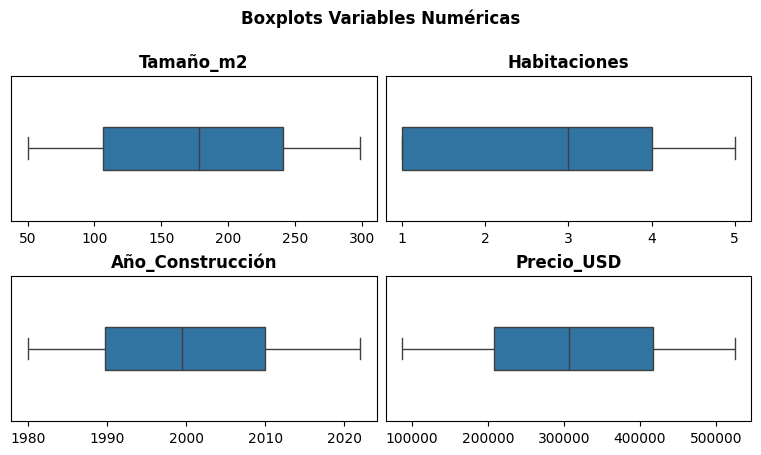

In [ ]:
# revisar outliers

fig, axs = plt.subplots(2, 2, figsize=(7.5, 4), layout='constrained')
axs = axs.ravel()

atributos = df.select_dtypes(include=['int64', 'float64'])

for i, col in enumerate(atributos):
  sns.boxplot(x=df[col], ax=axs[i], width=0.3)
  axs[i].set_title(col, weight='bold')
  axs[i].set_xlabel('')
  axs[i].set_yticks([])

plt.suptitle('Boxplots Variables Numéricas', weight='bold', y=1.1)
plt.show()

Acorde al análisis univariado, no se visualizan outliers.

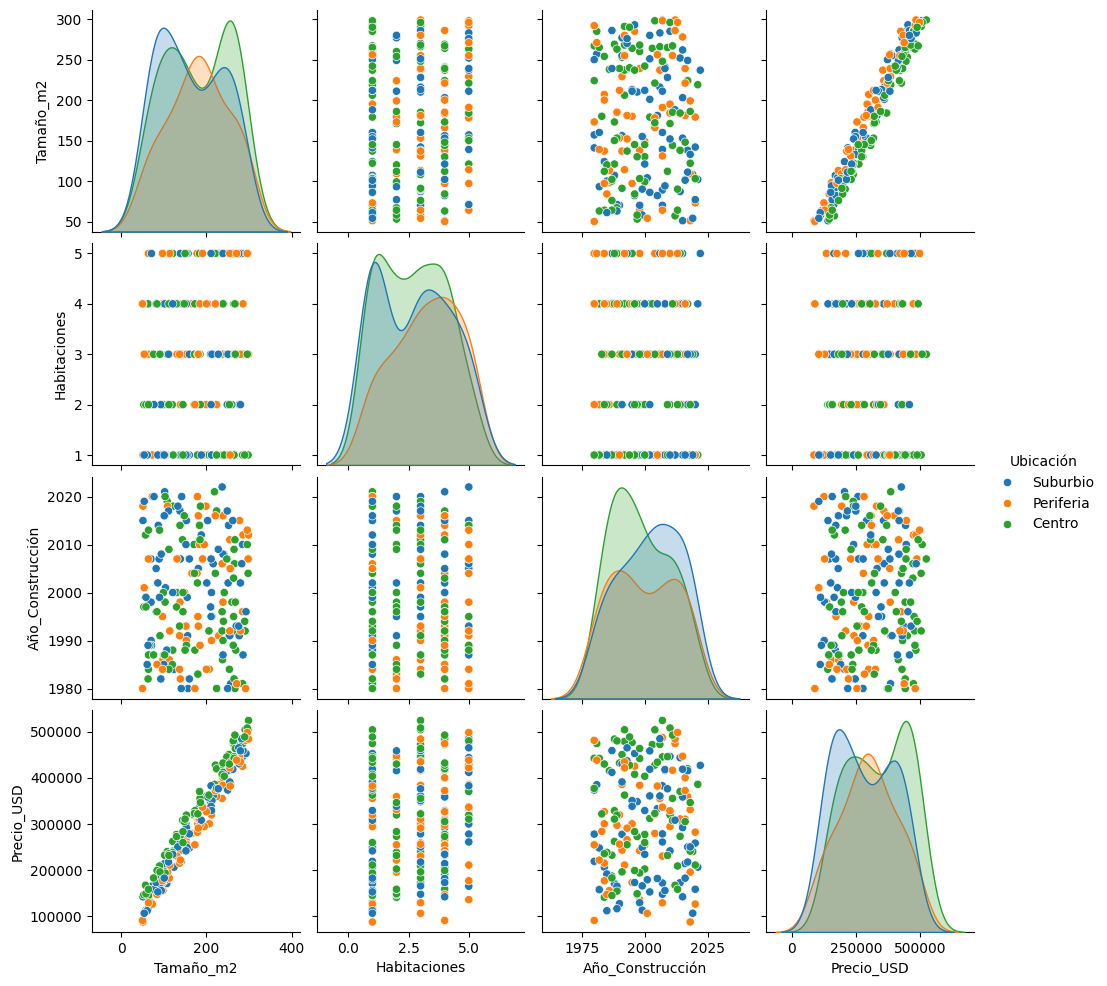

In [ ]:
sns.pairplot(df, hue='Ubicación')
plt.show()

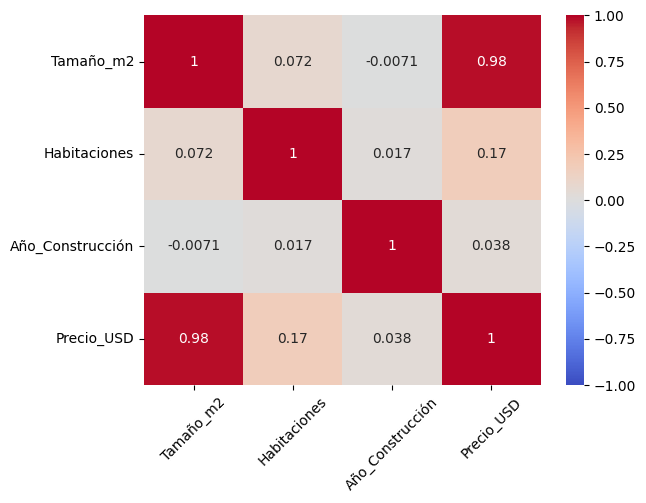

In [ ]:
# graficar correlación

sns.heatmap(df.drop(['Ubicación'], axis=1).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.show()

- Se visualiza una correlación positiva fuerte entre el tamaño y el precio de los inmuebles.
- Resto de las correlaciones son despreciables.

##**2. Aplicación de modelos de regresión**

In [ ]:
# transformar año de construcción en "edad"
df['edad'] = 2025 - df.Año_Construcción
df.head()

,Tamaño_m2,Habitaciones,Ubicación,Año_Construcción,Precio_USD,edad
0,152,5,Suburbio,2015,299781.0,10
1,229,5,Periferia,1991,385551.0,34
2,142,3,Suburbio,2020,258381.0,5
3,64,5,Periferia,1998,135449.0,27
4,156,4,Suburbio,1991,277521.0,34


In [ ]:
# aplicar One Hot Encooding a ubicación

ohe = OneHotEncoder(sparse_output=False, drop='first')
ubicacion_ohe = ohe.fit_transform(df[['Ubicación']])
ubicacion_ohe = pd.DataFrame(ubicacion_ohe, columns=ohe.get_feature_names_out())

df = pd.concat([df, ubicacion_ohe], axis=1)
df.head()

,Tamaño_m2,Habitaciones,Ubicación,Año_Construcción,Precio_USD,edad,Ubicación_Periferia,Ubicación_Suburbio
0,152,5,Suburbio,2015,299781.0,10,0.0,1.0
1,229,5,Periferia,1991,385551.0,34,1.0,0.0
2,142,3,Suburbio,2020,258381.0,5,0.0,1.0
3,64,5,Periferia,1998,135449.0,27,1.0,0.0
4,156,4,Suburbio,1991,277521.0,34,0.0,1.0


In [ ]:
# dividir el dataset en conjunto de entrenamiento y testeo

X = df.drop(columns=['Precio_USD', 'Año_Construcción', 'Ubicación'])
y = df.Precio_USD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('shape X_train =', X_train.shape)
print('shape X_test =', X_test.shape)
print('shape y_train =', y_train.shape)
print('shape y_test =', y_test.shape)

shape X_train = (160, 5)
shape X_test = (40, 5)
shape y_train = (160,)
shape y_test = (40,)


In [ ]:
# aplicar regresión lineal

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

scores = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_oof = np.round(scores.mean(), 0)
rmse_oof = np.round(np.mean([v**.5 for v in scores]), 0)

print(f'MSE OOF  = {mse_oof} USD^2')
print(f'RMSE OOF = {rmse_oof} USD')

MSE OOF  = 30760093.0 USD^2
RMSE OOF = 5528.0 USD


In [ ]:
# evaluar modelo en el conjunto de testeo

pipe.fit(X_train, y_train)

y_pred_lin = pipe.predict(X_test)

mse_test = np.round(mean_squared_error(y_test, y_pred_lin), 0)
rmse_test = np.round(mse_test**0.5, 0)

print(f'MSE test  = {mse_test} USD^2')
print(f'RMSE test = {rmse_test} USD')

# registrar datos para posterior comparación entre modelos
resultados = {}
resultados['regresión lineal'] = {'mse_oof': mse_oof, 'mse_test': mse_test, 'rmse_oof': rmse_oof, 'rmse_test': rmse_test}

MSE test  = 40058143.0 USD^2
RMSE test = 6329.0 USD


**Regresión Polinómica:**

- Transforma las variables de entrada utilizando características polinómicas de grado 2.
- Ajusta un modelo de regresión lineal sobre los datos transformados.
- Calcula el error cuadrático medio y compara con la regresión lineal.

In [ ]:
# crear variables polinónicas y entrenar modelo lineal

pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

scores = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_oof = np.round(scores.mean(), 0)
rmse_oof = np.round(np.mean([v**.5 for v in scores]), 0)

print(f'MSE OOF  = {mse_oof} USD^2')
print(f'RMSE OOF = {rmse_oof} USD')

MSE OOF  = 33167223.0 USD^2
RMSE OOF = 5740.0 USD


In [ ]:
# evaluar modelo en el conjunto de testeo

pipe.fit(X_train, y_train)

y_pred_lin_cuad = pipe.predict(X_test)

mse_test = np.round(mean_squared_error(y_test, y_pred_lin_cuad), 0)
rmse_test = np.round(mse_test**0.5, 0)

print(f'MSE test  = {mse_test} USD^2')
print(f'RMSE test = {rmse_test} USD')

resultados['regresión lineal con atributos cuadráticos'] = {'mse_oof': mse_oof, 'mse_test': mse_test, 'rmse_oof': rmse_oof, 'rmse_test': rmse_test}

MSE test  = 36361486.0 USD^2
RMSE test = 6030.0 USD


**Comentario:**
- Regresión Lineal: MSE test = 40058143.0 USD^2
- Regresión Lineal con atributos cuadráticos: MSE test = 36361486.0 USD^2

El modelo de regresión lineal con características polinómicas adicionales tiene un MSE ligeramente menor en el conjunto de prueba en comparación con el modelo de regresión lineal estándar, lo que sugiere un rendimiento ligeramente mejor en la predicción de los precios de las propiedades.

**Árbol de Decisión:**
- Implementa un modelo de regresión basado en árboles de decisión.
- Evalúa el rendimiento del modelo usando MSE y analiza su capacidad de generalización.

In [ ]:
# crear variables polinómicas y entrenar modelo Decision Tree

pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_split=3, min_samples_leaf=3))
])

scores = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

mse_oof = np.round(scores.mean(), 0)
rmse_oof = np.round(np.mean([v**.5 for v in scores]), 0)

print(f'MSE OOF  = {mse_oof} USD^2')
print(f'RMSE OOF = {rmse_oof} USD')

MSE OOF  = 746826298.0 USD^2
RMSE OOF = 27185.0 USD


In [ ]:
# evaluar modelo en el conjunto de testeo

pipe.fit(X_train, y_train)

y_pred_ar_cuad = pipe.predict(X_test)

mse_test = np.round(mean_squared_error(y_test, y_pred_ar_cuad), 0)
rmse_test = np.round(mse_test**0.5, 0)

print(f'MSE test  = {mse_test} USD^2')
print(f'RMSE test = {rmse_test} USD')

resultados['regresión árbol con atributos cuadráticos'] = {'mse_oof': mse_oof, 'mse_test': mse_test, 'rmse_oof': rmse_oof, 'rmse_test': rmse_test}

MSE test  = 474844470.0 USD^2
RMSE test = 21791.0 USD


**Comentario:**

Analizando la capacidad de generalización del modelo de Árbol de Decisión, podemos observar los siguientes resultados:

- MSE OOF: 746826298.0 USD^2
- RMSE OOF: 27185.0 USD
- MSE test: 474844470.0 USD^2
- RMSE test: 21791.0 USD

En este caso particular, el MSE y RMSE en el conjunto de test son menores que en el OOF (validación cruzada), lo cual podría indicar que el modelo no está sobreajustando excesivamente a los datos de entrenamiento y tiene una capacidad de generalización razonable para este conjunto de datos específico. Sin embargo, comparado con los modelos de regresión lineal, los errores son considerablemente mayores, lo que sugiere que para este problema, el árbol de decisión no generaliza tan bien como los modelos lineales.

En general, los árboles de decisión tienen el potencial de sobreajustar si no se controlan con parámetros como max_depth, min_samples_split, y min_samples_leaf. En este caso, con los parámetros utilizados, parece que se ha logrado una generalización aceptable para un árbol de decisión, aunque no supera el rendimiento de los modelos lineales en este conjunto de datos.

##**3. Análisis de resultados**

In [ ]:
pd.DataFrame(resultados).T

,mse_oof,mse_test,rmse_oof,rmse_test
regresión lineal,30760093.0,40058143.0,5528.0,6329.0
regresión lineal con atributos cuadráticos,33167223.0,36361486.0,5740.0,6030.0
regresión árbol con atributos cuadráticos,746826298.0,474844470.0,27185.0,21791.0


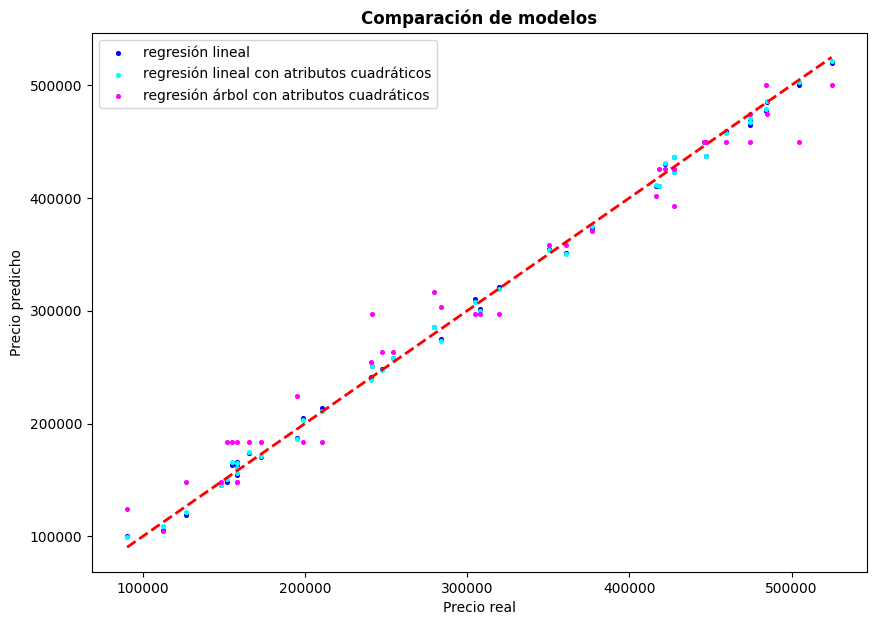

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_lin, label='regresión lineal', s=7, c='b')
plt.scatter(y_test, y_pred_lin_cuad, label='regresión lineal con atributos cuadráticos', s=7, c='cyan')
plt.scatter(y_test, y_pred_ar_cuad, label='regresión árbol con atributos cuadráticos', s=7, c='magenta')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Comparación de modelos', weight='bold')
plt.legend()
plt.show()

**Comparación de modelos:**

- Diferencias en los resultados y comparación de MSE: Al comparar los modelos de regresión lineal, regresión lineal con atributos cuadráticos y el árbol de decisión, se observa que los modelos lineales (ambos con y sin características polinómicas) obtienen MSE y RMSE significativamente menores en comparación con el árbol de decisión. Entre los dos modelos lineales, el que incluye atributos cuadráticos tiene un MSE ligeramente menor en el conjunto de prueba, sugiriendo un ajuste marginalmente mejor a los datos.
- Modelo que mejor se ajusta a los datos: Basándonos únicamente en el MSE en el conjunto de prueba, el modelo de regresión lineal con atributos cuadráticos parece ser el que mejor se ajusta a los datos de este conjunto en particular, aunque la diferencia con la regresión lineal simple es pequeña.

**Interpretación de predicciones:**

- Patrones observados: La gráfica de dispersión que compara los precios reales con los precios predichos muestra que los modelos de regresión lineal (con y sin atributos cuadráticos) tienden a seguir la línea de referencia (donde el precio real es igual al precio predicho) de manera más consistente que el árbol de decisión. Esto indica que los modelos lineales están haciendo predicciones más cercanas a los valores reales en general. El tamaño del inmueble parece ser el factor más influyente en la predicción del precio, dada la fuerte correlación observada.
- Adecuación para la toma de decisiones en compra/venta: Los modelos lineales, al tener errores de predicción (RMSE) en el rango de los 6000-7000 USD, podrían ser útiles como una herramienta inicial para tener una estimación general del precio. Sin embargo, dado que el rango de precios es amplio, un error de miles de dólares podría ser significativo en una transacción inmobiliaria. Por lo tanto, aunque pueden proporcionar una idea general, no deberían ser la única base para tomar decisiones importantes de compra o venta. El modelo de árbol de decisión, con errores considerablemente mayores, sería menos adecuado para este propósito.

**Aplicabilidad:**

- Regresión Lineal: Es recomendable utilizar regresión lineal cuando se sospecha que existe una relación lineal entre las variables predictoras y la variable objetivo. Es un modelo simple, fácil de interpretar y eficiente computacionalmente, adecuado como punto de partida o cuando la relación es claramente lineal.
- Regresión Polinómica: Es útil cuando la relación entre las variables no es estrictamente lineal, pero se puede modelar mediante curvas. Permite capturar relaciones más complejas que la regresión lineal simple sin recurrir a modelos más complejos. En este caso, vimos que mejoró ligeramente el rendimiento.
- Árboles de Decisión: Son versátiles y pueden capturar relaciones no lineales e interacciones entre variables automáticamente. Son útiles cuando la relación entre las variables es compleja y no se conoce de antemano. Sin embargo, como vimos, pueden ser más propensos a sobreajustar y, en este caso particular, no superaron a los modelos lineales en términos de error. Son más adecuados cuando la interpretabilidad de las "reglas" de decisión es importante o cuando se necesita un modelo que maneje bien datos con estructuras no lineales complejas.

En resumen, la elección del modelo depende de la naturaleza de la relación entre las variables, la complejidad deseada del modelo y la importancia de la interpretabilidad.